# How to group users and identify outliers in a log stream, based on behaviour

## What is demonstrated in this notebook

In this notebook I demonstrate, from a (generated) stream of logs, how to group users by behaviour, and how to highlight which behaviour group an analyst should focus his attention on. 

This method is good when monitoring a stable and closed system, with a finite number of possible actions and known definition of success and failure.

Probabilities are based on a "Subject (unique key), Action (ex.: login), Outcome (success/fail)" discrete format. Continuous Action variables would need to be reduced to discrete output to fit this model.

## Why is this a hard problem?

What is a normal action? Which one is suspect? The answer is "it depends". 

To group individual together, we need a way to classify each action taken over time, and somehow group them together. A clustering function like KMean requires us to know how many cluster we have, and we need mesurable features to group them together. Normal clustering functions lose in efficiency the more we add features.

Machine learning techniques are also great to identify patterns over a large number of repeating features, but struggle to handle unusual events especially when data is skewed by a high volume of "normal" actions. This is why in text analysis we normally remove common [English stop words](https://www.ranks.nl/stopwords). But what if these stop words were necessary to identfy an outlier? How can we keep them without debalancing everything?

One other hypothesis would be to use Hidden Markov Chains, but for HNN, we need classified data. Sequences also need to be somehow of a consistent length, but users are most likely not to follow a straight pattern from A to B, which complicates the creation of HMM.

Another approach would be to use rules. Classically, Intrusion detection systems recognize a set of patterns, and uses thresholds to know when to raise a flag, generating a large number of false positive. A rule based system is also unlikely to be able to detect the usage of normal functions in an abusive way.

In the end, we need each features from all possible events to be classified and scored somehow, and we need a way to group these scores together.

## Approach taken

### What this notebook is the following

* Step 1: We calculate the probability of each sequences of actions being taken by all users over a defined period of time (ex.: 1 day). From these probabilities, we create a lookup table for each possible sequence.
* Step 2: For each users, we sum the probability (using logarithm base 2) for each action taken. Depending on the likelyhood of each action, this will create different profiles per user.
* Step 3: Using the profile created on Step 2, we group them together by calculating the "distance" between all actions. If the distance is small, then the users have similar behaviour profile. If the distance is far, then they have different behaviour.
* Step 4: With all users grouped together, we can quickly analyse a group of user and label that group with a usage profile. This profile shouldn't change over time. If new behaviours are observed, new groups will be created. An analyst then only have to pay attention to the new group and groups identified as malicious when monitoring a system.

### Caviats

* For Step 1, this can be done on a live stream of logs, but for systems generating a large quantify of logs, this could result in integer overflow. Using rolling windows (ex.: calculate for a period, then use these probabilities distribution to analyse the next period, while creating a new distribution for the next period) might be a better solution.
* For Step 2, this works better when there is a clear start and end of sequence for a user. As it is coded right now, scoring a partial session would end up creating a large quantity of behaviour group, which could be noisy. However, this could be interesting to identify a list of "opening moves".
* For Step 3, the "distance" between each users is somewhat arbitrary selected. If we impose a short maximum distance (ex.: 5, 0 being perfectly identical), then this method will generate a large number of groups to represent all possible behaviours, but if we use a larger maximum distance (ex.: 10), then we increase the likelihood of having misclassifications and group outlier with normal users.
* For Step 4: None here :-D This is where I would start configuring rules or send data to a machine learning model, because users are now classified in limited groups.

## The theory behind the approach

Information Theory is normally used for signal analysis and compression. By using Surprisal Analysis and Kullback–Leibler divergence, we can group similar behaviour togethers.

* [Information Content](https://en.wikipedia.org/wiki/Information_content)
* [Surprisal Analysis](https://en.wikipedia.org/wiki/Surprisal_analysis)
* [Kullback–Leibler divergence](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence)
* [Example of Surprisal](http://www.umsl.edu/~fraundorfp/egsurpri.html)

Basically, Surprisal Analysis is a way to measure (in bits) how surprised we should be when looking at a specific behaviour. 

For example:
* There is 1/6 chance to roll a 6 on a d6 die, gives us -log2(1/6) ~= 2.4849 bits of information. If you are playing D&D, you will be happily surprised.
* Not rolling a 6 on a die represents -log2(5/6) ~= 0.263 bits. So rolling anything but a 6 in that same D&D game will most likely leave you dissapointed. 
* The chance of rolling 10 x 6 in a row on a die is 1/60466176 (10 * -log2(1/6) ~= 25.85 bits). This is highly unlikely.

So later when we look at the surprisal score of a user and we see 51550 (bits), this tells us that what this user did is really, really unlikely.

This also tells us that if the total surprisal score of the actions of a user is low, then we can safely assume that the actions taken by that user are normal.

Surprisal are calculated using Log base 2, which has the nice particularity to be additive instead of being multiplied like probabilities, keeping numbers relatively small and easy to manipulate.

This is what this notebook intend to demonstrate: Using Surprisal analysis, we will assign a score to actions, and by adding up the score of each action, identify series of actions that are unlikely to occur.


# Step 0: We need logs

What is explained in this notebook can be applied to real logs, but for the experimentation, I generate logs for simulated users based on a determined probability distribution.

## Caviat: I use some cheats to demonstrate how the notebook works...

But these cheats are not necessary to make this technique work. However, I did use that cheat at first to identify the most efficient "distance" to use in Step 3. 


## Different User Profiles Generated By The Library

The following profiles are being generated.

Normal users
* Buyer
* Merchants

Abnormal users:
* Scraper bots
* Spammers
* fraudster
* Account Attackers

Buyers and merchants represent 98% of our logs. Leaving 2% to the abnormal users. However, the actions taken by each users being on a probability distribution. 

It is possible to see an "attakcer" user being classified as a user, because that attacked might have had a change of heart and didn't attack after all. This allows us to demonstrate that this approach is not perfect: a small quantity of unlikely actions will most probably pass under the radar if we just look at the score of each user. That attacker might however be identified if the actions doesn't match the ones of normal users, which would generate a new group and single him/her out.


In [1]:
## This cell initialize the libraries needed for this notebook, 
## along with the blackbox functions used to generate the users and logs

import random
import numpy as np
import pandas as pd
from datetime import datetime, date, time, timedelta
from math import log, pow

%load_ext autoreload
%autoreload 2

from blackbox import distribution as user_profile_distribution
from blackbox import generate_userlist, generate_logs, cheat_calculate_hit_rate, cheat_lookup_all_users

magic = user_profile_distribution()

# Step 0.1: Generating The User Database

The following cells generates our users.

Note: I often reinitializing the random seed, just to keep the testing consistence. Setting *random_seed* to False will generate new data every time.

In [2]:
## Initial number of users in our system
number_of_daily_users = 3000 # The more we add users, the longer the notebook takes to run.

In [3]:
random_seed = 42

if random_seed:
    random.seed(random_seed)

all_user_lists = [] # Later on, we can add users to our list by supplying it to the generate_userlist function

## We define how many new users to add
number_of_new_users = number_of_daily_users - len(all_user_lists)

all_user_lists = generate_userlist(all_user_lists, number_of_new_users)
todays_user_lists = random.sample(all_user_lists, number_of_daily_users)

print(len(todays_user_lists), 'users in the database. Type of the 15 firsts:', todays_user_lists[:15])

3000 users in the database. Type of the 15 firsts: ['buyer', 'buyer', 'merchant', 'merchant', 'merchant', 'buyer', 'merchant', 'buyer', 'buyer', 'merchant', 'merchant', 'spammer', 'merchant', 'merchant', 'buyer']


# Step 0.2: Generating Logs For Day 1

Note: The more users we have, the more log events will be generated. The probability distribution of each user ensures that they will start with a defined action, crawl the site following a defined pattern, and logout eventually, until the end of the day.

In [4]:
%%time
if random_seed:
    random.seed(random_seed)

start_time = datetime(2019,1,1,0,0)
day1_logs = generate_logs(todays_user_lists, start_time)

print(len(day1_logs), 'log events generated for', len(todays_user_lists), 'users')

69095 log events generated for 3000 users
CPU times: user 17.8 s, sys: 87 ms, total: 17.9 s
Wall time: 18 s


## Transforming the logs in a pandas dataframe (for this notebook...)

The transition surprisal lookup table used in this notebook calculates scores based on the movements of the users between each actions. For example:

* login -> view_items (success) will result in a low surpisal value
* login -> buy_item (success) never happened. If this sequence happen, this should be a huge red flag.

Notice that there is one level skipped here: the status of the previous path isn't taken into consideration. Adding it would definitely make the calculations more sensitive to anomalies, but with the cost of an increase on complexity.

In [5]:
def transform_logs_to_pandas(logs):
    data = pd.DataFrame(np.array(logs), columns=['time', 'user', 'path', 'status', 'uidx', 'realtype'])
    
    data['prev_path'] = data.groupby(['user'])['path'].shift(1)
    data['prev_path'] = data['prev_path'].fillna("")

    data['prev_status'] = data.groupby(['user'])['status'].shift(1)
    data['prev_status'] = data['prev_status'].fillna("")
    return data
    
day1_data = transform_logs_to_pandas(day1_logs)


# Example of failed actions in the logs. uidx and realtype are "cheat" columns, and not necessary in a real case usage.

print(day1_data.loc[(day1_data['path'] == 'login') & (day1_data['status'] == 'fail')].head())

                    time          user   path status  uidx  realtype  \
2    2019-01-01 00:01:14      buyer166  login   fail   166     buyer   
4    2019-01-01 00:01:35      buyer166  login   fail   166     buyer   
200  2019-01-01 00:14:55  attacker2467  login   fail  2467  attacker   
202  2019-01-01 00:15:00  attacker2467  login   fail  2467  attacker   
204  2019-01-01 00:15:01  attacker2467  login   fail  2467  attacker   

    prev_path prev_status  
2                          
4       login        fail  
200                        
202     login        fail  
204     login        fail  


## Step 1 : Generate the transition lookup table

**This is where the magic happens.**

The following cell generates the transition lookup table used to score each actions taken by the users.

The format is as follow:

```
['current path'],['previous path']: {
    'fail': 0, # How many time this action transition failed. (ex. View Items: Success, from: Login: Success)
    'success': 13, # How many time this action transition succeded (ex. View Items: Fail, from: Login: Success)
    'fsurprisal': 11.266786540694902, # Surprisal value if there is a failure happens
    'ssurprisal': 7.56634682255381 # Surprisal value if that action is successful.
    }
```

The surprisal value is directly related to the likelihood of an actions happening. If an actions is observed successfully few million times, then the successful surprisal value will be really low. However, the failure surprisal will be much higher if it never happens.

In [6]:
def init_transition_surprisal_lookup(data, key, prev_key, feature, success):
    surprisal = {}

    for pkey in data[key].unique():
        data_for_pkey = data.loc[(data[key] == pkey)]
        denum = len(data.loc[(data[key] == pkey)])

        for ppkey in data_for_pkey[prev_key].unique():
            ds = data_for_pkey.loc[(data_for_pkey[prev_key] == ppkey) & (data_for_pkey[feature] == success)]
            df = data_for_pkey.loc[(data_for_pkey[prev_key] == ppkey) & (data_for_pkey[feature] != success)]

            dsuccess = len(ds) * 1.0
            dfail = len(df) * 1.0

            if dsuccess == 0:
                dsuccess = 1.0 

            if dfail == 0:
                dfail = 1.0

            if (pkey not in surprisal.keys()):
                surprisal[pkey] = {}

            surprisal[pkey][ppkey] = {
                'success': len(ds), 
                'fail': len(df), 
                'ssurprisal': log(1/(dsuccess / denum),2), # Magic!!
                'fsurprisal': log(1/(dfail / denum),2), # Magic!!
            }
    return surprisal

transition_surprisal = init_transition_surprisal_lookup(day1_data, 'path', 'prev_path', 'status', 'success')

The next cell creates a wrapper function for the transition surprisal lookup table. If the sequence was previously observed, it will return it, and will return the probability of 1 over the total number of actions taken (unlikely) for unobserved events, making them stand out.

In [7]:
def get_transition_surprisal(path, prev_path, surprisal, data):
    if path not in list(surprisal.keys()):
        denum = len(data)
        return {
            'fail': 0,
            'success': 0,
            'ssurprisal': log(1/(1/denum),2),
            'fsurprisal': log(1/(1/denum),2),
        }
    else:
        if prev_path not in list(surprisal[path].keys()):
            denum = len(data.loc[(data['path'] == path)])
            return {
                'fail': 0,
                'success': 0,
                'ssurprisal': log(1/(1/denum),2),
                'fsurprisal': log(1/(1/denum),2),
            }
        else:
            return surprisal[path][prev_path]

# Usage example: what is the surprisal values for a "buy_item" action 
# if the user just logged in on the previous action?
get_transition_surprisal('buy_item', 'login', transition_surprisal, day1_data)

{'fail': 1,
 'fsurprisal': 11.903128676812319,
 'ssurprisal': 7.095773754754716,
 'success': 28}

# Step 2: For each users, sum the probability for each action taken.

The following function takes the dataframe with all the logs for a day, and returns the sum of the surprisal values, conditional to a success or a failure, for each actions taken by a user.

In [8]:
def get_user_transition_score(data, surprisal, key, feature, success_val):
    accumulator = {}
    key_last_path = {}
    
    for index,row in data.iterrows():
        if row[key] not in key_last_path.keys():
            key_last_path[row[key]] = ""
            
        if row[key] not in accumulator.keys():
            accumulator[row[key]] = {k:0 for k in data[feature].unique()}
            
        if row[feature] is success_val:
            accumulator[row[key]][row[feature]] += get_transition_surprisal(row[feature],key_last_path[row[key]], surprisal, data)['ssurprisal']
        else:
            accumulator[row[key]][row[feature]] += get_transition_surprisal(row[feature],key_last_path[row[key]], surprisal, data)['fsurprisal']

        key_last_path[row[key]] = row[feature]
                                    
    return accumulator


user_transition_score = get_user_transition_score(day1_data, transition_surprisal, 'user', 'path', 'success')

## Optional (but useful): Identify how shady are each outliers

The following three cells calculate the mean and standard deviation of each users, and display the users with a score of 2 or more standard deviations.

In [9]:
cumulative_score = [[v,sum(user_transition_score[v].values())] for v in [k for k in list(user_transition_score.keys())]]

df_cumulative_score = pd.DataFrame(cumulative_score, columns=['user', 'surprisal'])

avg = df_cumulative_score['surprisal'].mean()
std = df_cumulative_score['surprisal'].std()
df_cumulative_score['z'] = (df_cumulative_score['surprisal'] - avg) / std


In [10]:
# List all users with a zscore over 2.
df_cumulative_score.loc[df_cumulative_score['z'] >= 2].sort_values(by=['surprisal'], ascending=False)

,user,surprisal,z
1451,bot1392,34192.771972,30.525805
2407,bot831,29638.440077,26.438511
910,bot524,22653.550349,20.169908
1972,bot2148,18399.108431,16.351751
529,bot202,17577.598547,15.614486
1204,bot1387,17495.991605,15.541248
870,bot194,8600.834908,7.558272
315,bot1972,8094.871867,7.104195
502,bot691,7153.671801,6.259513
76,bot1183,6756.518015,5.903087


In [11]:
# List the 10 most boring users.
df_cumulative_score.sort_values(by=['surprisal'], ascending=False).tail(10)

,user,surprisal,z
2226,buyer966,20.231532,-0.142406
222,attacker1130,16.531092,-0.145727
1553,attacker721,16.531092,-0.145727
1834,attacker1073,16.531092,-0.145727
120,fraudster1293,11.545447,-0.150202
1546,buyer2158,11.545447,-0.150202
1335,buyer1840,11.545447,-0.150202
2904,merchant142,11.545447,-0.150202
649,buyer540,11.545447,-0.150202
2998,buyer238,4.985645,-0.156089


## Cheat cell: Identify the ideal "distance" to increase the True Positive rate, and reduce the False Positive Rate

Without using this cheat, we need to guess the ideal "distance". From experimentation, this should be between 4 and 8. 9 and more will cause a higher rate of False Positive.

In [12]:
np.seterr(divide='ignore', invalid='ignore', over='ignore')

if random_seed:
    np.random.seed(random_seed)

maxlimit = 1
maxtp = 0
mintn = 1
best_flat_lookup = {}

for l in range(2, 10):
    flat_status, flat_lookup = cheat_calculate_hit_rate(day1_data, user_transition_score, l)
    if maxtp <= flat_lookup[True][True] and mintn >= flat_lookup[True][False]:
        maxtp = flat_lookup[True][True]
        mintn = flat_lookup[True][False]
        maxlimit = l
        print('best', l, flat_lookup, maxtp, mintn, (maxtp+mintn)/2,maxlimit)
    

flat_status, flat_lookup = cheat_calculate_hit_rate(day1_data, user_transition_score, maxlimit)

print('limit', maxlimit)
print('count', True, flat_status[True])
print('count', False, flat_status[False])

print('percent', True, flat_lookup[True])
print('percent', False, flat_lookup[False])


best 2 {True: {True: 0.9354838709677419, False: 0.12112308194580476}, False: {True: 0.06451612903225806, False: 0.8788769180541952}} 0.9354838709677419 0.12112308194580476 0.5283034764567733 2
limit 2
count True {True: 165, False: 13}
count False {True: 380, False: 2691}
percent True {True: 0.9269662921348315, False: 0.12373819602735266}
percent False {True: 0.07303370786516854, False: 0.8762618039726473}


In [13]:
# Bypassing the cheat function and forcing the maximum distance.
maxlimit = 5

# Step 3: Grouping users by their behaviour

In [14]:
# Calculating the distance between profiles requires to convert log base 2 back to probabilities, 
# which sometimes causes overflow when profiles are too far apart. We can safely ignore these errors
np.seterr(divide='ignore', invalid='ignore', over='ignore') 

# If new actions are observed and are missing, we need to 1) ignore them, or 2) add them for the calculation
# This function ensure that both profiles has the same keys, and asign a value of 0 if it was missing
# Profiles and keys are returned in order of key names
def align_profiles(profile1, profile2):
    if profile1.keys() != profile2.keys():
        for k in profile1.keys():
            if k not in profile2.keys():
                profile2[k] = profile1[k]
        for k in profile2.keys():
            if k not in profile1.keys():
                profile1[k] = profile2[k]
    p1 = [value for (key, value) in sorted(profile1.items())]
    p2 = [value for (key, value) in sorted(profile2.items())]
    allkeys = [key for (key, value) in sorted(profile2.items())]
    return p1, p2, allkeys

# Magic here too!
# this function calculate the proximity between two profiles
# The Kullback-Leibler function isn't symetric, so A could be close to B, but B be absolutely different to A
# This is why we calculate the two possible distance (a/b and b/a)
# The return value is True if the two profiles are within the limit distance, else it returns False
def compare_profiles(profile1, profile2, limit = 7):
    u1, u2, trash = align_profiles(profile1, profile2)
    
    # Ref: https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence#Definition
    px = [1/np.power(2,x) for x in np.array(u1)]    
    qx = [1/np.power(2,x) for x in np.array(u2)]
    
    p = np.array(qx)/np.array(px)
    q = np.array(px)/np.array(qx)
    dklp = (qx * np.log2(p)).sum()
    dklq = (px * np.log2(q)).sum()
    
    # dklp/dlklq == Divergence Kullback-Leibler for p and q
    t = (dklp < limit and dklp >= -limit) and (dklq < limit and dklq >= -limit)
    
    return {'test': t, 'dklp': dklp, 'dklq': dklq}

# Example of usage
test_users = random.sample(user_transition_score.keys(),2)
print(test_users[0], user_transition_score[test_users[0]])
print(test_users[1], user_transition_score[test_users[1]])
compare_profiles(user_transition_score[test_users[0]], user_transition_score[test_users[1]], maxlimit)

merchant1159 {'login': 4.985644707022931, 'view_item': 94.19583408958562, 'comment': 0, 'buy_item': 0, 'logout': 0, 'end': 11.545447181678094, 'sell_item': 83.69866845609923, 'home': 0, 'bank_modify': 0, 'view_profile': 0, 'update_address': 0, 'update_email': 0, 'password_reset': 0, 'payment_modify': 0}
buyer1515 {'login': 4.985644707022931, 'view_item': 67.7400193361843, 'comment': 0, 'buy_item': 53.12436221098946, 'logout': 10.867278739709663, 'end': 11.545447181678094, 'sell_item': 0, 'home': 0, 'bank_modify': 0, 'view_profile': 0, 'update_address': 0, 'update_email': 0, 'password_reset': 0, 'payment_modify': 0}


{'dklp': 83.69285085506084, 'dklq': 63.991640950699122, 'test': False}

In [15]:
# This function is used to calculate the average profile for a behaviour group.
# The idea is that it will align the profiles first, then calculate the average of the values for each keys
def compile_average_for_type(array):
    garbage = {}
    for i in range(len(array)):
        if len(garbage.keys()) == 0:
            garbage = array[i]
        else:
            g, a, allkeys = align_profiles(garbage, array[i])
            c = np.array(g) + np.array(a)
            for idx in range(len(allkeys)):
                garbage[allkeys[idx]] = c[idx] 
    for k in garbage.keys():
        garbage[k] = garbage[k] / len(array)
    return garbage

# Example of usage
array = [{'a':1,'b':2,'c':3}, {'a':1,'b':2,'c':3}, {'a':1,'b':2,'c':3, 'd':4}, {'a':3,'b':1,'c':4}]
compile_average_for_type(array)

{'a': 1.5, 'b': 1.75, 'c': 3.25, 'd': 4.0}

In [16]:
# Once classified, this function will add to the identified class
# If the target class does not exist yet (the classification function returns an 
# inexistant class the candidate didn't match any existing profile)
# Then the function will add the candidate to that class.
def add_candidate_to_behaviour_group(candidate_name, matching_class, behaviour_group_table):  
    if matching_class not in behaviour_group_table.keys():
        behaviour_group_table[matching_class] = []

    if candidate_name not in behaviour_group_table[matching_class]:
        behaviour_group_table[matching_class].append(candidate_name)
        
    return candidate_name

In [17]:
# This is a cleanup function. If a user is already a member of a class, it will be removed 
# to be reclassified again
# If the class is empty once cleaned, it will stay emptied since another candidate 
# might have that profile later one.
def remove_from_classification(candidate_name, behaviour_group_table):
    cleaneds = [] # convention, I put s to array variables
    empties = []
    for be, be_list in behaviour_group_table.items():
        if candidate_name in behaviour_group_table[be]:
            behaviour_group_table[be].remove(candidate_name)
            cleaneds.append(be)
        if len(behaviour_group_table[be]) == 0:
            empties.append(be)
    for e in empties:
        del behaviour_group_table[e]
            
    return cleaneds       

# This function compares the candidates to the saved average calculated for each behaviour group
def classify_candidates_average(candidate_name, behaviour_type_average, score, limit = 7):
    potential_matching_type = {}
    passing_score = 0.9
    sample_size = 10
    small_size_adjustment = 2
    
    for be, be_average in behaviour_type_average.items():
        post = 0.1 # this is the prior

        result = compare_profiles(score[candidate_name], be_average, limit)
            
        if result['test'] == True:
            potential_matching_type[be] = post

    if len(potential_matching_type.keys()) == 0:
        new_class_name = max(0,len(list(behaviour_type_average.values())))
        return new_class_name
    else:
        return max(potential_matching_type, key=potential_matching_type.get)

# This is a helper function that calls all the actions in order for all unclassified users
# The candidate is selected at random from the list to prevent behaviour_class skewing if a batch of close users has
# slightly similar behaviours.
# The recalculation of the average only happens on the first value, and later one at each 4 profiles.
# Profiles selected to calculate the average are also selected at random to try to keep the average balanced over time
# This is also to prevent behaviour group polution. An earlier version was using Bayes probability update to test 
# a candidate against multiple members of a class, which had a bad side effect: If the maxmimum allowed distance is 5, 
# the first value might be 5, the second, could be between 0 and 10 and would be found as a match, then the following
# could stretch until 15, and so on. If enough tests were made, because we know that the classification is normally
# quite accurate, this would allow group to degenerate.
def classify_users_in_list(unclassified_user_lists, behaviour_group_table, behaviour_average_table, score, limit = 7):
    # select one user
    candidate_name = random.choice(unclassified_user_lists)
    if candidate_name:
        # classify user
        cleanup = remove_from_classification(candidate_name, behaviour_group_table)
        
        matching_class = classify_candidates_average(candidate_name, behaviour_average_table, score, limit)

        # add the user to the proper type
        add_candidate_to_behaviour_group(candidate_name, matching_class, behaviour_group_table)
        if len(behaviour_group_table[matching_class]) % 4 == 0 or len(behaviour_group_table[matching_class]) == 1:
            scores_for_users = random.sample(
                [score[x] for x in behaviour_group_table[matching_class]], 
                min(len(behaviour_group_table[matching_class]),10)
            )
            behaviour_average_table[matching_class] = compile_average_for_type(scores_for_users)
        unclassified_user_lists.remove(candidate_name)

## Extract the users to classify from the observed active users

The following cell initialize the behaviour_group_table and behaviour_average_table variables.
Then we get the list of observed users, and we create a list of unclassified users to classify

In [18]:
if random_seed:
    random.seed(random_seed)

behaviour_group_table = {}
behaviour_average_table = {}
print(len(list(user_transition_score.keys())))
unclassified_user_lists = random.sample(list(user_transition_score.keys()), min(len(todays_user_lists), len(list(user_transition_score.keys()))))

2999


The next cell is heavy to run. This is where we go through the list of unclassified users and we add them in the proper group.

Note: *behaviour_group_table* and *behaviour_average_table* are modified by the subfunctions

In [19]:
%%time
while len(unclassified_user_lists):
    classify_users_in_list(unclassified_user_lists, behaviour_group_table, behaviour_average_table, user_transition_score, maxlimit)

CPU times: user 12 s, sys: 38.9 ms, total: 12.1 s
Wall time: 12.1 s


## Cheat cell: List all behaviour groups and the number of user by their real type

This cell is only to demonstrate that the previous functions mostly group users by their good real time.
There are some misclassifications, this could be caused by the randomness of the actions taken by the generated users. 

Also, an attacker's action could look exactly like a real user. In these cases, we will most probably won't be able to identify that that user was an attacker, unless other actions were taken that would separate the behaviour profile from a normal user.

In [20]:
for k in behaviour_group_table.keys():
        type_average = np.mean([sum(user_transition_score[x].values()) for x in behaviour_group_table[k]])
        print(k, type_average, len(behaviour_group_table[k]), cheat_lookup_all_users(behaviour_group_table[k]))

0 126.597730317 746 {'merchant': 746}
1 93.7006802612 798 {'buyer': 798}
2 165.106230106 274 {'buyer': 274}
3 82.1226685229 251 {'buyer': 251}
4 159.379639992 96 {'buyer': 96}
5 143.359317165 731 {'merchant': 731}
6 249.880103456 1 {'buyer': 1}
7 191.368894111 6 {'buyer': 5, 'fraudster': 1}
8 244.894155926 2 {'buyer': 2}
9 249.65153609 1 {'buyer': 1}
10 29.4321473213 2 {'merchant': 2}
11 34192.7719717 1 {'bot': 1}
12 365.215886043 3 {'merchant': 3}
13 40.7688380859 11 {'buyer': 11}
14 1092.99622918 1 {'bot': 1}
15 184.666656114 3 {'merchant': 3}
16 19.556956114 10 {'buyer': 2, 'attacker': 5, 'fraudster': 2, 'merchant': 1}
17 169.155946646 5 {'spammer': 5}
18 122.43986214 1 {'buyer': 1}
19 209.73582516 4 {'merchant': 4}
20 37.0202139404 3 {'buyer': 1, 'attacker': 2}
21 192.750208925 3 {'spammer': 3}
22 343.179525931 2 {'merchant': 2}
23 175.363943864 3 {'merchant': 3}
24 71.0088488556 2 {'fraudster': 2}
25 4.98564470702 1 {'buyer': 1}
26 6756.51801549 1 {'bot': 1}
27 44.817450904 7 {'me

# Step 4: Analyse the behaviour groups, and lighlight which group contains outliers

This sections demonstrates how we can visualise and classify each group of behaviours. 

In [21]:
# This cell creates an helper function to generate a graph of the number of users in each behaviour group

import matplotlib.pyplot as plt
plt.style.use('ggplot')
import matplotlib

def graph_user_distribution_by_behaviour_id(type_table, average_table, transition_score):  
    current_behaviour_state_table = {}
    for k in type_table.keys():
        type_average = np.mean([sum(transition_score[x].values()) for x in type_table[k]])
        current_behaviour_state_table[k] = {'type': k, 'score':type_average, 'nbmembers':len(type_table[k]), 'behaviour': average_table[k]}
    
    plt.figure(figsize=(20,5))

    index = np.array(list(current_behaviour_state_table.keys()))
    names = list(type_table.keys())
    v1 = [current_behaviour_state_table[x]['nbmembers'] for x in names]
    plt.figure(1, figsize=(9, 5))

    bar_width = 0.4
    spare_width = (1 - bar_width*2)/2

    rects1 = plt.bar(index, v1, bar_width,
                    color='b',
                    label='Nb Members')

    plt.xlabel('Behaviour Group ID')
    plt.ylabel('Number of Users')
    plt.title('Number of User Per Behaviour Group')
    plt.xticks(index)
    plt.grid()
    plt.legend()
    return plt

In [23]:
# This cell creates an helper function that displays the distribution of actions for each group.
# Note that the surprisal value for a single action is maxed out at 500. More than this, the graph
# becomes useless since all normal actions squashed by the outliers

def graph_surprisal_distribution_by_action(type_table, average_table, transition_score):
    current_behaviour_state_table = {}
    for k in type_table.keys():
        type_average = np.mean([sum(transition_score[x].values()) for x in type_table[k]])
        current_behaviour_state_table[k] = {'type': k, 'score':type_average, 'nbmembers':len(type_table[k]), 'behaviour': average_table[k]}
    
    surprisal_stats = np.array([
        [current_behaviour_state_table[y]['behaviour'][x] for x in sorted(current_behaviour_state_table[1]['behaviour'].keys())]
#         [current_behaviour_state_table[y]['behaviour'][x]/sum(current_behaviour_state_table[y]['behaviour'].values()) for x in sorted(current_behaviour_state_table[1]['behaviour'].keys())]
        for y in [x for x in list(current_behaviour_state_table.keys()) if current_behaviour_state_table[x]['nbmembers'] > 0]
    ]).T
    
    keylists_columns = [x for x in sorted(list(current_behaviour_state_table.keys())) if current_behaviour_state_table[x]['nbmembers'] > 0]
    if len(keylists_columns) > 0:
        path_rows = sorted(current_behaviour_state_table[keylists_columns[0]]['behaviour'].keys())

        fig = plt.figure()
        ax = fig.add_subplot(111)
        fig = matplotlib.pyplot.gcf()
        fig.set_size_inches(20.0,7.5)

        # https://matplotlib.org/examples/color/colormaps_reference.html
        colors = plt.cm.Paired(np.linspace(0, 1, len(path_rows)))

        n_rows = len(surprisal_stats)

        index = np.arange(len(keylists_columns)) + 0.4
        bar_width = 0.4
        opacity=0.4
        spare_width = (1 - bar_width*2)/2

        ax.set_xlim(-spare_width,len(index)-spare_width)
        ax.set_ylabel("Surprisal Distribution")
        xTickMarks = keylists_columns

        ax.set_xticks(index+bar_width)

        xtickNames = ax.set_xticklabels(xTickMarks)
        plt.setp(xtickNames, rotation=0, fontsize=40)
        ax.yaxis.grid()

        y_offset = np.zeros(len(keylists_columns))

        # Plot bars and create text labels for the table
        cell_text = []
        for row in range(n_rows):
            plt.bar(index, np.minimum(surprisal_stats[row],500), bar_width, bottom=y_offset, color=colors[row])
            y_offset = y_offset + np.minimum(surprisal_stats[row],500)
            cell_text.append(['%.1f' % x for x in surprisal_stats[row]])

        # Add a table at the bottom of the axes
        the_table = plt.table(cellText=cell_text,
                              rowLabels=path_rows,
                              rowColours=colors,
                              alpha=opacity,
                              colLabels=keylists_columns,
                              loc='bottom')
        the_table.scale(1,2.5)
        the_table.auto_set_font_size(value=False)

        # Adjust layout to make room for the table:
        plt.subplots_adjust(left=0.2, bottom=0.2)
        ax.xaxis.labelpad = 260
        ax.yaxis.labelpad = 20

        plt.xticks([])
        plt.title('Distribution Of Actions By Behaviour Type')
    return plt


## Graph the behaviour groups and the count of members

<module 'matplotlib.pyplot' from '/Users/simon/anaconda/lib/python3.6/site-packages/matplotlib/pyplot.py'>

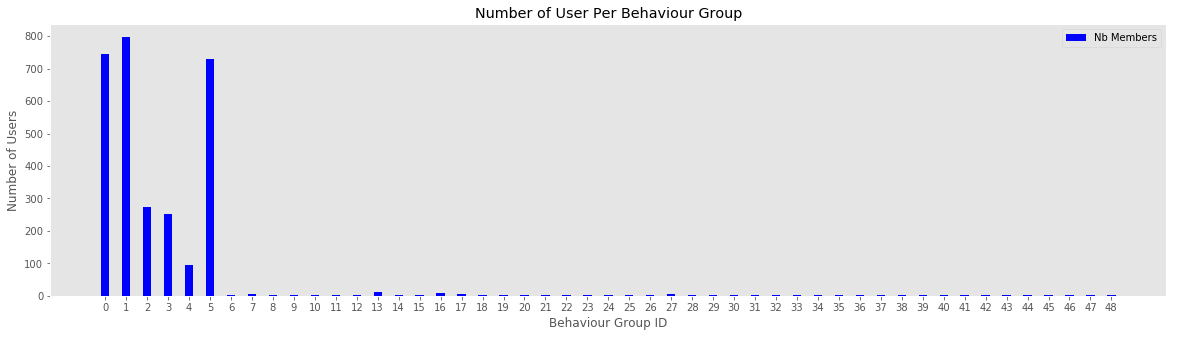

In [24]:
graph_user_distribution_by_behaviour_id(behaviour_group_table, behaviour_average_table, user_transition_score)

## Graph the distribution of by action, weighted by their surprisal score

How to read the graph: 
* Compare the previous graph and this one
* Groups with high number of users and a low surprisal distribution should mainly represent normal users. 
* The different colors should also help to identify which action was mainly used by these users

How to spot outliers?
* Look for groups with a low number of users and a high surprisal distribution.
* The bottom table with the list of actions and scores can also be used to understand the bar above. Low values represent normal actions, high values represents outliers.
* With the distribution of test users used in this notebook, bots should be the main offenders.

Note: The graph below is probably not the best long term solution to graph behaviour groups since it will tend to be crowded with time. It's just for the prouf of concept.

<module 'matplotlib.pyplot' from '/Users/simon/anaconda/lib/python3.6/site-packages/matplotlib/pyplot.py'>

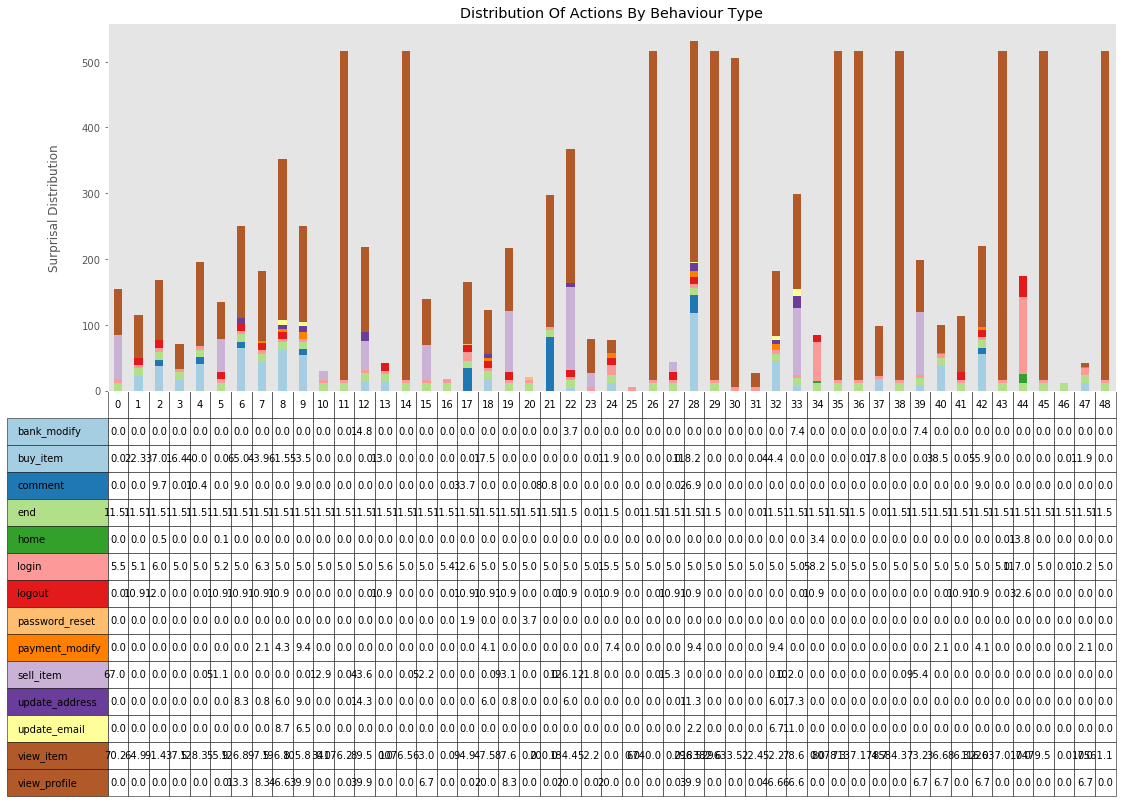

In [25]:
graph_surprisal_distribution_by_action(behaviour_group_table, behaviour_average_table, user_transition_score)

# 4.1 Investigate the behaviour groups to understand the behaviour of the members

The following cell extracts the cound of actions for each member of a designated group.


In [26]:
behaviour_group_to_analyse = 43

df_investigate = day1_data.loc[day1_data['user'].isin(behaviour_group_table[behaviour_group_to_analyse])]
df_investigate.groupby(['user', 'status', 'path']).size().unstack(fill_value=0)

path                  bank_modify  end  login  sell_item  update_address  \
user         status                                                        
merchant1098 fail               0    0      0          1               1   
             success            2    1      1          9               4   

path                  update_email  view_item  view_profile  
user         status                                          
merchant1098 fail                1          0             0  
             success             3          7            10

# What next: Repeating the analysis on following days

Now that all functions are defined, we can collect logs on subsequent days and classify the users with the previously identified behaviour groups.

If users change their behaviour, they will be reclassified. Inactive users will stay where they are.

Except the "merge_user_transition_score" function, all functions called were previously used. I simply adjusted them to analyse the logs of a different day, in which 200 new users registered.

Logs are also limited to the daily number of users defined at the beginning of the notebook. This means that some users will come back, and some won't. If a user is reclassified, some behaviour group might end up being empty. They will be represented by empty column indexes, but the behaviour average is preserved for further classification if needed. 

In [27]:
# New day
start_time = datetime(2019,1,2,0,0)

# Changing the initial seed to get different results
if random_seed:
    random.seed(random_seed + 1)

# How many new users registered today
number_of_new_users = 200
all_user_lists = generate_userlist(all_user_lists, number_of_new_users)

# Select which users will login today
todays_user_lists = random.sample(all_user_lists, number_of_daily_users)

print('Number of active users today:', len(todays_user_lists), todays_user_lists[:5])

if random_seed:
    random.seed(random_seed + 1)
# Generate the logs for the day for the active users
day2_logs = generate_logs(todays_user_lists, start_time)

print(len(day2_logs), 'logs events generated for', len(todays_user_lists), 'users')

# Prepare the data for analysis, by converting them in a pandas dataframe
day2_data = transform_logs_to_pandas(day2_logs)

Number of active users today: 3000 ['merchant', 'buyer', 'merchant', 'buyer', 'merchant']
81832 logs events generated for 3000 users


In [28]:
# Calculate the user transition score based on the previous day surprisal lookup table. 
# We could have recompile is here as well, but this is to be consistant with the suggestion to compare users against
# a previously calculated transition table.
user_transition_score_day2 = get_user_transition_score(day2_data, transition_surprisal, 'user', 'path', 'success')

## Merge the previously calculated transition scores with the new ones
The next function takes the new transition scores calculated for the second day, and add the values from day 1 for the missing users. This is done to allow us to compare new profiles with previous users when behaviour groups averages are reclaculated.

In [29]:
def merge_user_transition_score(original, newtransitions):        
    for key in original.keys():
        if key not in newtransitions.keys():
            newtransitions[key] = original[key]

    return newtransitions

user_transition_score_merged = merge_user_transition_score(user_transition_score, user_transition_score_day2)
len(user_transition_score_merged)

4546

## Optional (but useful): Identifying unclassified outliers

Same as done on day 1, we can identify outliers just by listing the ones with 2 standard deviations and more.

In [30]:
cumulative_score = [[v,sum(user_transition_score_merged[v].values())] for v in [k for k in list(user_transition_score_merged.keys())]]

df_cumulative_score = pd.DataFrame(cumulative_score, columns=['user', 'surprisal'])

avg = df_cumulative_score['surprisal'].mean()
std = df_cumulative_score['surprisal'].std()
df_cumulative_score['z'] = (df_cumulative_score['surprisal'] - avg) / std

df_cumulative_score.loc[df_cumulative_score['z'] >= 2].sort_values(by=['surprisal'], ascending=False)

,user,surprisal,z
766,bot240,106017.762003,53.350231
3735,bot1392,34192.771972,17.134004
4229,bot831,29638.440077,14.837579
143,bot2780,27103.848929,13.559565
559,bot477,25422.745920,12.711905
509,bot1692,24911.342416,12.454041
3463,bot524,22653.550349,11.315597
2449,bot183,20477.365225,10.218302
522,bot1450,18866.988233,9.406303
4010,bot2148,18399.108431,9.170385


In [31]:
if random_seed:
    random.seed(random_seed)

unclassified_user_lists = random.sample(list(user_transition_score_merged.keys()), min(len(todays_user_lists), len(list(user_transition_score_merged.keys()))))
print(len(unclassified_user_lists))

3000


In [32]:
%%time

# Classifying observed users
while len(unclassified_user_lists):
    classify_users_in_list(unclassified_user_lists, behaviour_group_table, behaviour_average_table, user_transition_score_merged, maxlimit)

CPU times: user 25.1 s, sys: 105 ms, total: 25.2 s
Wall time: 25.4 s


In [33]:
# Cheat cell: list all groups with the distribution of their users, by real type

for k in sorted(behaviour_group_table.keys()):
    type_average = np.mean([sum(user_transition_score_merged[x].values()) for x in behaviour_group_table[k]])
    print(k, type_average, len(behaviour_group_table[k]), cheat_lookup_all_users(behaviour_group_table[k]))

0 137.085321251 1262 {'merchant': 1262}
1 102.285467702 569 {'buyer': 569}
2 157.054044738 345 {'buyer': 345}
3 92.0571943776 670 {'buyer': 670}
4 133.096646896 55 {'buyer': 55}
5 133.351300167 284 {'merchant': 284}
6 75.3384737556 1 {'buyer': 1}
7 181.37947633 4 {'buyer': 3, 'fraudster': 1}
8 244.894155926 2 {'buyer': 2}
9 249.65153609 1 {'buyer': 1}
10 75.7149724417 2 {'merchant': 2}
11 34192.7719717 1 {'bot': 1}
12 193.345571213 5 {'merchant': 5}
13 57.4597311728 7 {'buyer': 7}
15 232.815195288 7 {'merchant': 7}
16 82.9709666099 118 {'fraudster': 2, 'attacker': 6, 'buyer': 110}
17 165.136035105 7 {'spammer': 7}
18 122.43986214 1 {'buyer': 1}
19 198.702615172 1 {'merchant': 1}
20 36.7870271328 7 {'attacker': 4, 'fraudster': 3}
21 175.210140107 5 {'spammer': 5}
22 289.152078462 3 {'merchant': 3}
23 144.355716471 2 {'merchant': 2}
24 71.0088488556 2 {'fraudster': 2}
25 28.3528775122 2 {'buyer': 2}
27 127.938838022 3 {'merchant': 3}
28 410.621363334 3 {'buyer': 3}
31 133.241830943 430 {

## Graph the behaviour groups and the count of members

<module 'matplotlib.pyplot' from '/Users/simon/anaconda/lib/python3.6/site-packages/matplotlib/pyplot.py'>

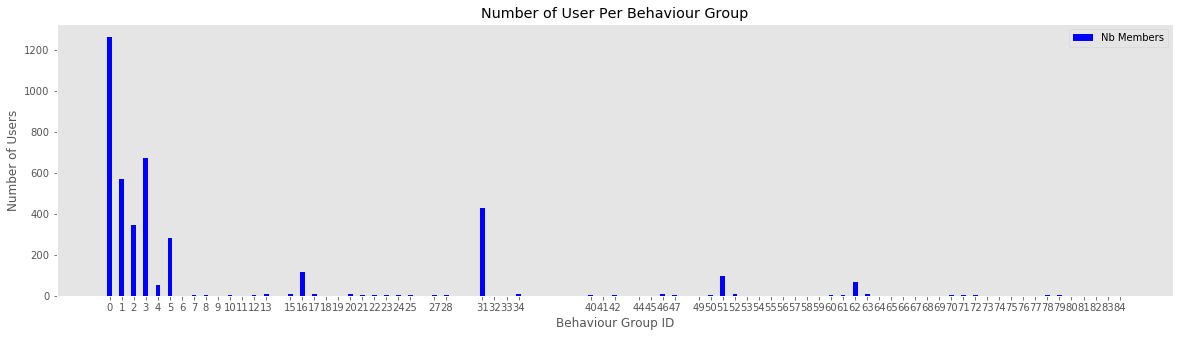

In [34]:
graph_user_distribution_by_behaviour_id(behaviour_group_table, behaviour_average_table, user_transition_score_merged)

## Graph the distribution of by action, weighted by their surprisal score

<module 'matplotlib.pyplot' from '/Users/simon/anaconda/lib/python3.6/site-packages/matplotlib/pyplot.py'>

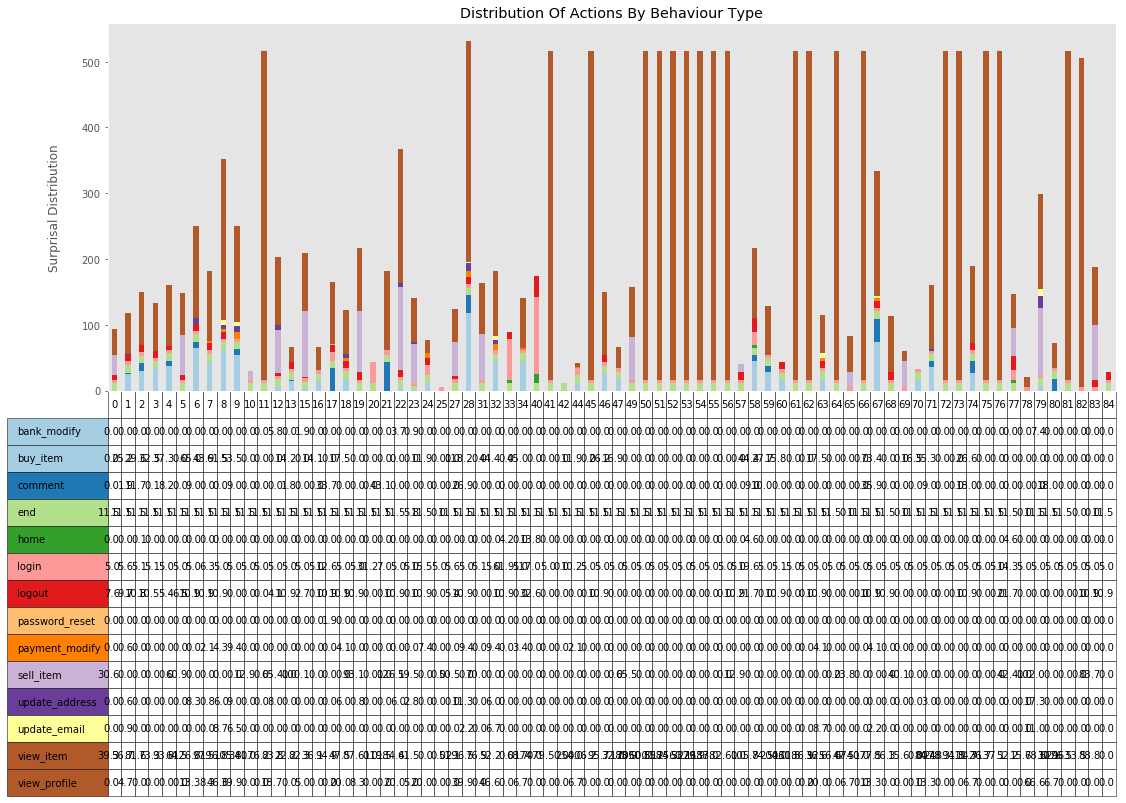

In [35]:
graph_surprisal_distribution_by_action(behaviour_group_table, behaviour_average_table, user_transition_score_merged)

## Investigate the behaviour groups to understand the behaviour of the members

In [36]:
behaviour_group_to_analyse = 84

df_investigate = day2_data.loc[day2_data['user'].isin(behaviour_group_table[behaviour_group_to_analyse])]
df_investigate.groupby(['user', 'status', 'path']).size().unstack(fill_value=0)

,path,end,login,logout
user,status,,,
fraudster75,success,1,1,1
